### Adam

Epoch 1: loss=1.4759, accuracy=0.7914, val_loss=1.4843, val_accuracy=0.8242
Epoch 2: loss=1.5119, accuracy=0.8469, val_loss=1.6092, val_accuracy=0.8422
Epoch 3: loss=1.6396, accuracy=0.8584, val_loss=1.7394, val_accuracy=0.8494
Epoch 4: loss=1.7702, accuracy=0.8669, val_loss=1.8594, val_accuracy=0.8617
Epoch 5: loss=1.9023, accuracy=0.8743, val_loss=2.0043, val_accuracy=0.8622
Epoch 6: loss=2.0310, accuracy=0.8801, val_loss=2.1342, val_accuracy=0.8676
Epoch 7: loss=2.1583, accuracy=0.8848, val_loss=2.2612, val_accuracy=0.8708
Epoch 8: loss=2.2834, accuracy=0.8901, val_loss=2.3865, val_accuracy=0.8735
Epoch 9: loss=2.4067, accuracy=0.8939, val_loss=2.5086, val_accuracy=0.8759
Epoch 10: loss=2.5237, accuracy=0.8975, val_loss=2.6277, val_accuracy=0.8785
Epoch 11: loss=2.6404, accuracy=0.9005, val_loss=2.7480, val_accuracy=0.8792
Epoch 12: loss=2.7547, accuracy=0.9035, val_loss=2.8624, val_accuracy=0.8812
Epoch 13: loss=2.8664, accuracy=0.9063, val_loss=2.9783, val_accuracy=0.8819
Epoch 14

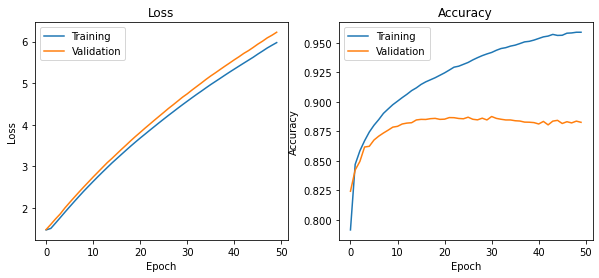

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.datasets import mnist
import pandas as pd
import pickle
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

class MLP:
    def __init__(self, n_inputs, n_hidden, n_outputs):
        self.W1 = np.random.normal(loc=0.0, scale=1.0, size=(n_inputs, n_hidden)) / np.sqrt(n_inputs)
        self.b1 = np.zeros(n_hidden)
        self.W2 = np.random.normal(loc=0.0, scale=1.0, size=(n_hidden, n_outputs)) / np.sqrt(n_hidden)
        self.b2 = np.zeros(n_outputs)
        self.lambda_ = 0.01 # Regularization parameter

################################################# Forward Pass #####################################################
    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.h1 = np.maximum(self.z1, 0)
        self.z2 = self.h1 @ self.W2 + self.b2
        exp_z2 = np.exp(self.z2)
        self.probs = exp_z2 / np.sum(exp_z2, axis=1, keepdims=True)
        return self.probs
    
##################################################### Backward Pass #####################################################

    def backward(self, y, X, L2_reg_lambda=0.01):
        grad = self.probs - y
        self.d_W2 = self.h1.T @ grad + L2_reg_lambda * self.W2
        self.d_b2 = np.sum(grad, axis=0)
        d_h1 = grad @ self.W2.T
        d_z1 = d_h1.copy()
        d_z1[self.z1 < 0] = 0
        self.d_W1 = X.T @ d_z1 + L2_reg_lambda * self.W1
        self.d_b1 = np.sum(d_z1, axis=0)


    def update_parameters_adam(self, grad, learning_rate, beta1, beta2, epsilon):
        self.t += 1
        self.m_W2 = beta1 * self.m_W2 + (1 - beta1) * self.d_W2
        self.v_W2 = beta2 * self.v_W2 + (1 - beta2) * np.square(self.d_W2)
        m_W2_hat = self.m_W2 / (1 - beta1 ** self.t)
        v_W2_hat = self.v_W2 / (1 - beta2 ** self.t)
        self.W2 -= learning_rate * m_W2_hat / (np.sqrt(v_W2_hat) + epsilon)
        self.m_b2 = beta1 * self.m_b2 + (1 - beta1) * self.d_b2
        self.v_b2 = beta2 * self.v_b2 + (1 - beta2) * np.square(self.d_b2)
        m_b2_hat = self.m_b2 / (1 - beta1 ** self.t)
        v_b2_hat = self.v_b2 / (1 - beta2 ** self.t)
        self.b2 -= learning_rate * m_b2_hat / (np.sqrt(v_b2_hat) + epsilon)
        self.m_W1 = beta1 * self.m_W1 + (1 - beta1) * self.d_W1
        self.v_W1 = beta2 * self.v_W1 + (1 - beta2) * np.square(self.d_W1)
        m_W1_hat = self.m_W1 / (1 - beta1 ** self.t)
        v_W1_hat = self.v_W1 / (1 - beta2 ** self.t)
        self.W1 -= learning_rate * m_W1_hat / (np.sqrt(v_W1_hat) + epsilon)
        self.m_b1 = beta1 * self.m_b1 + (1 - beta1) * self.d_b1
        self.v_b1 = beta2 * self.v_b1 + (1 - beta2) * np.square(self.d_b1)
        self.v_b1_hat = self.v_b1 / (1 - beta2 ** self.t)
        self.b1 -= learning_rate * self.m_b1 / (np.sqrt(self.v_b1_hat) + epsilon)
        

#################### Updating values for adam and passing them ###########################################################3
    def train(self, X, y, X_val, y_val, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8,
              epochs=20, batch_size=64, print_progress=True, l2_reg=0.01):
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        self.t = 0
        self.m_W2 = np.zeros_like(self.W2)
        self.v_W2 = np.zeros_like(self.W2)
        self.m_b2 = np.zeros_like(self.b2)
        self.v_b2 = np.zeros_like(self.b2)
        self.m_W1 = np.zeros_like(self.W1)
        self.v_W1 = np.zeros_like(self.W1)
        self.m_b1 = np.zeros_like(self.b1)
        self.v_b1 = np.zeros_like(self.b1)
        train_losses, train_accuracies = [], []
        val_losses, val_accuracies = [], []
        test_losses, test_accuracies = [], []

        for epoch in range(epochs):
            epoch_loss = 0
            epoch_accuracy = 0
            for i in range(0, n_samples, batch_size):
                # Mini-batch gradient descent
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]

                # Forward pass
                probs = self.forward(X_batch)

                # Compute loss and accuracy
                loss = -np.sum(y_batch * np.log(probs)) / batch_size
                l2_loss = 0.5 * l2_reg * (np.sum(self.W1 ** 2) + np.sum(self.W2 ** 2))
                loss += l2_loss
                epoch_loss += loss
                epoch_accuracy += np.mean(np.argmax(probs, axis=1) == np.argmax(y_batch, axis=1))

                # Backward pass
                self.backward(y_batch, X_batch, l2_reg)

                # Update parameters with Adam optimizer
                self.update_parameters_adam(y_batch, learning_rate, beta1, beta2, epsilon)

            # Compute validation loss and accuracy
            val_probs = self.forward(X_val)
            val_loss = -np.sum(y_val * np.log(val_probs)) / X_val.shape[0]
            val_l2_loss = 0.5 * l2_reg * (np.sum(self.W1 ** 2) + np.sum(self.W2 ** 2))
            val_loss += val_l2_loss
            val_accuracy = np.mean(np.argmax(val_probs, axis=1) == np.argmax(y_val, axis=1))

            train_losses.append(epoch_loss / n_batches)
            train_accuracies.append(epoch_accuracy / n_batches)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            if print_progress:
                print("Epoch {0}: loss={1:.4f}, accuracy={2:.4f}, val_loss={3:.4f}, val_accuracy={4:.4f}"
                      .format(epoch+1, train_losses[-1], train_accuracies[-1], val_losses[-1], val_accuracies[-1]))

        return train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies

# Load MNIST data
(X, y), (_, _) = fashion_mnist.load_data()

# Flatten and normalize
X = X.reshape(X.shape[0], -1) / 255.0

# Split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2/(1-0.2), random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

input_size = X_train.shape[1]
hidden_size = 128
output_size = 10
#learning_rate = 0.001
#batch_size = 128
epochs = 20

model = MLP(input_size, hidden_size, output_size)
train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies = model.train(X_train, y_train,
                                                                                                       X_val, y_val,
                                                                                                       learning_rate=0.001,
                                                                                                       beta1=0.9, beta2=0.999,
                                                                                                       epsilon=1e-8,
                                                                                                       epochs=50,
                                                                                                       batch_size=128,
                                                                                                       print_progress=True,
                                                                                                      l2_reg=0.01)

test_probs = model.forward(X_test)
test_accuracy = np.mean(np.argmax(test_probs, axis=1) == np.argmax(y_test, axis=1))
print("Test accuracy:", test_accuracy)

# Plot the training, validation, and test loss and accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training")
plt.plot(val_accuracies, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()

# Define file name and path
file_name = 'my_model.pkl'
file_path = 'C:/Users/HP/Desktop/'

# Open a file in write binary mode
with open(file_path + file_name, 'wb') as file:
    # Use dump() method to save the model to the file
    pickle.dump(model, file)

# Close the file
file.close()

### Rmsprop

Epoch 1: loss = 0.5983, accuracy = 0.7921, val_loss = 0.4567, val_accuracy = 0.8395
Epoch 2: loss = 0.4338, accuracy = 0.8463, val_loss = 0.3990, val_accuracy = 0.8560
Epoch 3: loss = 0.3832, accuracy = 0.8628, val_loss = 0.3714, val_accuracy = 0.8661
Epoch 4: loss = 0.3528, accuracy = 0.8737, val_loss = 0.3554, val_accuracy = 0.8704
Epoch 5: loss = 0.3311, accuracy = 0.8827, val_loss = 0.3438, val_accuracy = 0.8745
Epoch 6: loss = 0.3136, accuracy = 0.8885, val_loss = 0.3388, val_accuracy = 0.8768
Epoch 7: loss = 0.2988, accuracy = 0.8936, val_loss = 0.3342, val_accuracy = 0.8797
Epoch 8: loss = 0.2859, accuracy = 0.8982, val_loss = 0.3318, val_accuracy = 0.8807
Epoch 9: loss = 0.2747, accuracy = 0.9019, val_loss = 0.3235, val_accuracy = 0.8833
Epoch 10: loss = 0.2640, accuracy = 0.9063, val_loss = 0.3339, val_accuracy = 0.8828
Epoch 11: loss = 0.2543, accuracy = 0.9099, val_loss = 0.3296, val_accuracy = 0.8854
Epoch 12: loss = 0.2451, accuracy = 0.9146, val_loss = 0.3332, val_accurac

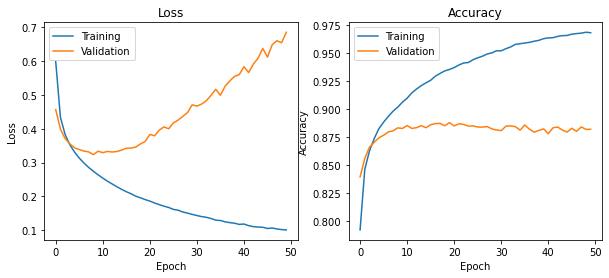

In [25]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

class MLP:
    def __init__(self, n_inputs, n_hidden, n_outputs):
        self.W1 = np.random.normal(loc=0.0, scale=1.0, size=(n_inputs, n_hidden)) / np.sqrt(n_inputs)
        self.b1 = np.zeros(n_hidden)
        self.W2 = np.random.normal(loc=0.0, scale=1.0, size=(n_hidden, n_outputs)) / np.sqrt(n_hidden)
        self.b2 = np.zeros(n_outputs)

    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.h1 = np.maximum(self.z1, 0)
        self.z2 = self.h1 @ self.W2 + self.b2
        exp_z2 = np.exp(self.z2)
        self.probs = exp_z2 / np.sum(exp_z2, axis=1, keepdims=True)
        return self.probs

    def backward(self, grad, X_batch):
        d_z2 = self.probs - grad
        self.d_W2 = self.h1.T @ d_z2
        self.d_b2 = np.sum(d_z2, axis=0)
        d_h1 = d_z2 @ self.W2.T
        d_z1 = d_h1.copy()
        d_z1[self.z1 < 0] = 0
        self.d_W1 = X_batch.T @ d_z1
        self.d_b1 = np.sum(d_z1, axis=0)
        
    def update_parameters_rmsprop(self, grad, learning_rate, beta, epsilon):
        self.d_W2_squared = beta * self.d_W2_squared + (1 - beta) * np.square(self.d_W2)
        self.W2 -= learning_rate * self.d_W2 / (np.sqrt(self.d_W2_squared) + epsilon)
        self.d_b2_squared = beta * self.d_b2_squared + (1 - beta) * np.square(self.d_b2)
        self.b2 -= learning_rate * self.d_b2 / (np.sqrt(self.d_b2_squared) + epsilon)
        self.d_W1_squared = beta * self.d_W1_squared + (1 - beta) * np.square(self.d_W1)
        self.W1 -= learning_rate * self.d_W1 / (np.sqrt(self.d_W1_squared) + epsilon)
        self.d_b1_squared = beta * self.d_b1_squared + (1 - beta) * np.square(self.d_b1)
        self.b1 -= learning_rate * self.d_b1 / (np.sqrt(self.d_b1_squared) + epsilon)

    def train(self, X, y, X_val, y_val, learning_rate=0.001, beta=0.9, epsilon=1e-8,
              epochs=10, batch_size=64, print_progress=True):
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        self.d_W2_squared = np.zeros_like(self.W2)
        self.d_b2_squared = np.zeros_like(self.b2)
        self.d_W1_squared = np.zeros_like(self.W1)
        self.d_b1_squared = np.zeros_like(self.b1)
        train_losses, train_accuracies = [], []
        val_losses, val_accuracies = [], []
        test_losses, test_accuracies = [], []
        for epoch in range(epochs):
            epoch_loss = 0
            epoch_accuracy = 0
            for i in range(0, n_samples, batch_size):
                # Mini-batch gradient descent
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]

                # Forward pass
                probs = self.forward(X_batch)

                # Compute loss and accuracy
                loss = -np.sum(y_batch * np.log(probs)) / batch_size
                epoch_loss += loss
                epoch_accuracy += np.mean(np.argmax(probs, axis=1) == np.argmax(y_batch, axis=1))

                # Backward pass
                self.backward(y_batch, X_batch)

                # Update parameters with RMSprop optimizer
                self.update_parameters_rmsprop(y_batch, learning_rate, beta, epsilon)

            # Compute validation loss and accuracy
            val_probs = self.forward(X_val)
            val_loss = -np.sum(y_val * np.log(val_probs)) / X_val.shape[0]
            val_accuracy = np.mean(np.argmax(val_probs, axis=1) == np.argmax(y_val, axis=1))

            train_losses.append(epoch_loss / n_batches)
            train_accuracies.append(epoch_accuracy / n_batches)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            if print_progress:
                print("Epoch {0}: loss = {1:.4f}, accuracy = {2:.4f}, val_loss = {3:.4f}, val_accuracy = {4:.4f}".format(
                    epoch+1, epoch_loss / n_batches, epoch_accuracy / n_batches, val_loss, val_accuracy))

        return train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies
    
    
# Load MNIST data
(X, y), (_, _) = fashion_mnist.load_data()

# Flatten and normalize
X = X.reshape(X.shape[0], -1) / 255.0

# Split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2/(1-0.2), random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)


input_size = X_train.shape[1]
hidden_size = 128
output_size = 10
#learning_rate = 0.001
#batch_size = 128
epochs = 10

model = MLP(input_size, hidden_size, output_size)
train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies = model.train(X_train, y_train,X_val, y_val,learning_rate=0.001,beta=0.9,epsilon=1e-8,epochs=50,batch_size=64,print_progress=True)

test_probs = model.forward(X_test)
test_accuracy = np.mean(np.argmax(test_probs, axis=1) == np.argmax(y_test, axis=1))
print("Test accuracy:", test_accuracy)

# Plot the training, validation, and test loss and accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training")
plt.plot(val_losses, label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training")
plt.plot(val_accuracies, label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()

## Adagrad


Epoch 1: loss = 0.8567, accuracy = 0.7337, val_loss = 0.6937, val_accuracy = 0.7752
Epoch 2: loss = 0.6567, accuracy = 0.7883, val_loss = 0.6252, val_accuracy = 0.7969
Epoch 3: loss = 0.6081, accuracy = 0.8035, val_loss = 0.5913, val_accuracy = 0.8072
Epoch 4: loss = 0.5799, accuracy = 0.8107, val_loss = 0.5692, val_accuracy = 0.8147
Epoch 5: loss = 0.5606, accuracy = 0.8168, val_loss = 0.5533, val_accuracy = 0.8197
Epoch 6: loss = 0.5462, accuracy = 0.8211, val_loss = 0.5410, val_accuracy = 0.8244
Epoch 7: loss = 0.5348, accuracy = 0.8241, val_loss = 0.5312, val_accuracy = 0.8260
Epoch 8: loss = 0.5255, accuracy = 0.8274, val_loss = 0.5230, val_accuracy = 0.8284
Epoch 9: loss = 0.5176, accuracy = 0.8298, val_loss = 0.5160, val_accuracy = 0.8306
Epoch 10: loss = 0.5109, accuracy = 0.8315, val_loss = 0.5100, val_accuracy = 0.8325
Epoch 11: loss = 0.5049, accuracy = 0.8332, val_loss = 0.5047, val_accuracy = 0.8329
Epoch 12: loss = 0.4997, accuracy = 0.8344, val_loss = 0.5000, val_accurac

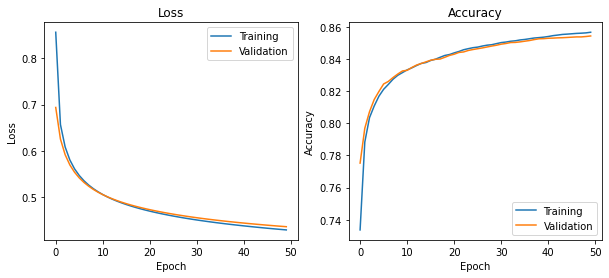

In [26]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

class MLP:
    def __init__(self, n_inputs, n_hidden, n_outputs):
        self.W1 = np.random.normal(loc=0.0, scale=1.0, size=(n_inputs, n_hidden)) / np.sqrt(n_inputs)
        self.b1 = np.zeros(n_hidden)
        self.W2 = np.random.normal(loc=0.0, scale=1.0, size=(n_hidden, n_outputs)) / np.sqrt(n_hidden)
        self.b2 = np.zeros(n_outputs)
        
    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.h1 = np.maximum(self.z1, 0)
        self.z2 = self.h1 @ self.W2 + self.b2
        exp_z2 = np.exp(self.z2)
        self.probs = exp_z2 / np.sum(exp_z2, axis=1, keepdims=True)
        return self.probs

    def backward(self, grad, X_batch):
        d_z2 = self.probs - grad
        self.d_W2 = self.h1.T @ d_z2
        self.d_b2 = np.sum(d_z2, axis=0)
        d_h1 = d_z2 @ self.W2.T
        d_z1 = d_h1.copy()
        d_z1[self.z1 < 0] = 0
        self.d_W1 = X_batch.T @ d_z1
        self.d_b1 = np.sum(d_z1, axis=0)

    def update_parameters_adagrad(self, grad, learning_rate, epsilon):
        self.d_W2_squared += np.square(self.d_W2)
        self.W2 -= learning_rate * self.d_W2 / (np.sqrt(self.d_W2_squared) + epsilon)
        self.d_b2_squared += np.square(self.d_b2)
        self.b2 -= learning_rate * self.d_b2 / (np.sqrt(self.d_b2_squared) + epsilon)
        self.d_W1_squared += np.square(self.d_W1)
        self.W1 -= learning_rate * self.d_W1 / (np.sqrt(self.d_W1_squared) + epsilon)
        self.d_b1_squared += np.square(self.d_b1)
        self.b1 -= learning_rate * self.d_b1 / (np.sqrt(self.d_b1_squared) + epsilon)

    def train(self, X, y, X_val, y_val, learning_rate=0.01, epsilon=1e-8,
              epochs=10, batch_size=64, print_progress=True):
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        self.d_W2_squared = np.zeros_like(self.W2)
        self.d_b2_squared = np.zeros_like(self.b2)
        self.d_W1_squared = np.zeros_like(self.W1)
        self.d_b1_squared = np.zeros_like(self.b1)
        train_losses, train_accuracies = [], []
        val_losses, val_accuracies = [], []
        test_losses, test_accuracies = [], []
        for epoch in range(epochs):
            epoch_loss = 0
            epoch_accuracy = 0
            for i in range(0, n_samples, batch_size):
                # Mini-batch gradient descent
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]

                # Forward pass
                probs = self.forward(X_batch)

                # Compute loss and accuracy
                loss = -np.sum(y_batch * np.log(probs)) / batch_size
                epoch_loss += loss
                epoch_accuracy += np.mean(np.argmax(probs, axis=1) == np.argmax(y_batch, axis=1))

                # Backward pass
                self.backward(y_batch, X_batch)

                # Update parameters with Adagrad optimizer
                self.update_parameters_adagrad(y_batch, learning_rate, epsilon)

            # Compute validation loss and accuracy
            val_probs = self.forward(X_val)
            val_loss = -np.sum(y_val * np.log(val_probs)) / X_val.shape[0]
            val_accuracy = np.mean(np.argmax(val_probs, axis=1) == np.argmax(y_val, axis=1))
            train_losses.append(epoch_loss / n_batches)
            train_accuracies.append(epoch_accuracy / n_batches)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            if print_progress:
                print("Epoch {0}: loss = {1:.4f}, accuracy = {2:.4f}, val_loss = {3:.4f}, val_accuracy = {4:.4f}".format(
                    epoch+1, epoch_loss / n_batches, epoch_accuracy / n_batches, val_loss, val_accuracy))

        return train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies
    
    
# Load MNIST data
(X, y), (_, _) = fashion_mnist.load_data()

# Flatten and normalize
X = X.reshape(X.shape[0], -1) / 255.0

# Split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2/(1-0.2), random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)


input_size = X_train.shape[1]
hidden_size = 128
output_size = 10
#learning_rate = 0.001
#batch_size = 128
epochs = 10

model = MLP(input_size, hidden_size, output_size)
train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies = model.train(X_train, y_train,X_val, y_val,learning_rate=0.001,epsilon=1e-8,epochs=50,batch_size=64,print_progress=True)

test_probs = model.forward(X_test)
test_accuracy = np.mean(np.argmax(test_probs, axis=1) == np.argmax(y_test, axis=1))
print("Test accuracy:", test_accuracy)

# Plot the training, validation, and test loss and accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training")
plt.plot(val_losses, label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training")
plt.plot(val_accuracies, label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()

Epoch 1: loss = 0.5879, accuracy = 0.7904, val_loss = 0.5312, val_accuracy = 0.7901
Epoch 2: loss = 0.4614, accuracy = 0.8361, val_loss = 0.3964, val_accuracy = 0.8539
Epoch 3: loss = 0.4243, accuracy = 0.8458, val_loss = 0.3843, val_accuracy = 0.8614
Epoch 4: loss = 0.3951, accuracy = 0.8567, val_loss = 0.3854, val_accuracy = 0.8629
Epoch 5: loss = 0.3709, accuracy = 0.8661, val_loss = 0.3647, val_accuracy = 0.8659
Epoch 6: loss = 0.3632, accuracy = 0.8674, val_loss = 0.3637, val_accuracy = 0.8676
Epoch 7: loss = 0.3496, accuracy = 0.8739, val_loss = 0.3598, val_accuracy = 0.8744
Epoch 8: loss = 0.3398, accuracy = 0.8768, val_loss = 0.3857, val_accuracy = 0.8575
Epoch 9: loss = 0.3286, accuracy = 0.8799, val_loss = 0.3527, val_accuracy = 0.8755
Epoch 10: loss = 0.3204, accuracy = 0.8833, val_loss = 0.3529, val_accuracy = 0.8767
Epoch 11: loss = 0.3124, accuracy = 0.8864, val_loss = 0.3485, val_accuracy = 0.8744
Epoch 12: loss = 0.3102, accuracy = 0.8889, val_loss = 0.3755, val_accurac

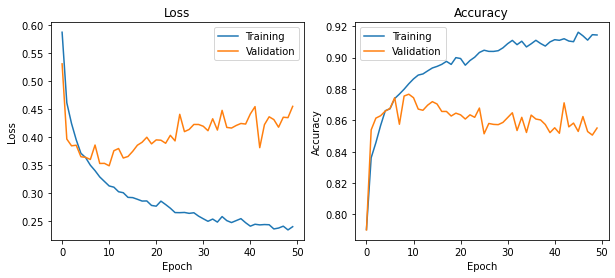

In [27]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

class MLP:
    def __init__(self, n_inputs, n_hidden, n_outputs):
        self.W1 = np.random.normal(loc=0.0, scale=1.0, size=(n_inputs, n_hidden)) / np.sqrt(n_inputs)
        self.b1 = np.zeros(n_hidden)
        self.W2 = np.random.normal(loc=0.0, scale=1.0, size=(n_hidden, n_outputs)) / np.sqrt(n_hidden)
        self.b2 = np.zeros(n_outputs)
        
    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.h1 = np.maximum(self.z1, 0)
        self.z2 = self.h1 @ self.W2 + self.b2
        exp_z2 = np.exp(self.z2)
        self.probs = exp_z2 / np.sum(exp_z2, axis=1, keepdims=True)
        return self.probs

    def backward(self, y, X, L2_reg_lambda=0.01):
        grad = self.probs - y
        self.d_W2 = self.h1.T @ grad + L2_reg_lambda * self.W2
        self.d_b2 = np.sum(grad, axis=0)
        d_h1 = grad @ self.W2.T
        d_z1 = d_h1.copy()
        d_z1[self.z1 < 0] = 0
        self.d_W1 = X.T @ d_z1 + L2_reg_lambda * self.W1
        self.d_b1 = np.sum(d_z1, axis=0)


    def update_parameters_gradient_descent_momentum(self, grad, learning_rate, momentum):
        self.V_d_W2 = momentum * self.V_d_W2 + learning_rate * self.d_W2
        self.W2 -= self.V_d_W2
        self.V_d_b2 = momentum * self.V_d_b2 + learning_rate * self.d_b2
        self.b2 -= self.V_d_b2
        self.V_d_W1 = momentum * self.V_d_W1 + learning_rate * self.d_W1
        self.W1 -= self.V_d_W1
        self.V_d_b1 = momentum * self.V_d_b1 + learning_rate * self.d_b1
        self.b1 -= self.V_d_b1

    def train(self, X, y, X_val, y_val, learning_rate=0.001, momentum=0.9,
        epochs=10, batch_size=64, print_progress=True):
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        self.V_d_W2 = np.zeros_like(self.W2)
        self.V_d_b2 = np.zeros_like(self.b2)
        self.V_d_W1 = np.zeros_like(self.W1)
        self.V_d_b1 = np.zeros_like(self.b1)
        train_losses, train_accuracies = [], []
        val_losses, val_accuracies = [], []
        test_losses, test_accuracies = [], []
        for epoch in range(epochs):
            epoch_loss = 0
            epoch_accuracy = 0
            for i in range(0, n_samples, batch_size):
                # Mini-batch gradient descent
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]

                # Forward pass
                probs = self.forward(X_batch)

                # Compute loss and accuracy
                loss = -np.sum(y_batch * np.log(probs)) / batch_size
                epoch_loss += loss
                epoch_accuracy += np.mean(np.argmax(probs, axis=1) == np.argmax(y_batch, axis=1))

                # Backward pass
                self.backward(y_batch, X_batch)

                # Update parameters with gradient descent with momentum optimizer
                self.update_parameters_gradient_descent_momentum(y_batch, learning_rate, momentum)

            # Compute validation loss and accuracy
            val_probs = self.forward(X_val)
            val_loss = -np.sum(y_val * np.log(val_probs)) / X_val.shape[0]
            val_accuracy = np.mean(np.argmax(val_probs, axis=1) == np.argmax(y_val, axis=1))
            train_losses.append(epoch_loss / n_batches)
            train_accuracies.append(epoch_accuracy / n_batches)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            if print_progress:
                print("Epoch {0}: loss = {1:.4f}, accuracy = {2:.4f}, val_loss = {3:.4f}, val_accuracy = {4:.4f}".format(
                    epoch+1, epoch_loss / n_batches, epoch_accuracy / n_batches, val_loss, val_accuracy))

        return train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies
    
# Load MNIST data
(X, y), (_, _) = fashion_mnist.load_data()

# Flatten and normalize
X = X.reshape(X.shape[0], -1) / 255.0

# Split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2/(1-0.2), random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)


input_size = X_train.shape[1]
hidden_size = 128
output_size = 10
#learning_rate = 0.001
#batch_size = 128
epochs = 10

model = MLP(input_size, hidden_size, output_size)
train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies = model.train(X_train, y_train,X_val, y_val,learning_rate=0.001, momentum=0.9,
        epochs=50, batch_size=64, print_progress=True)

test_probs = model.forward(X_test)
test_accuracy = np.mean(np.argmax(test_probs, axis=1) == np.argmax(y_test, axis=1))
print("Test accuracy:", test_accuracy)

# Plot the training, validation, and test loss and accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training")
plt.plot(val_losses, label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training")
plt.plot(val_accuracies, label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()

### Nesterov

Epoch 1: loss = 0.5374, accuracy = 0.8082, val_loss = 0.4476, val_accuracy = 0.8332
Epoch 2: loss = 0.4096, accuracy = 0.8522, val_loss = 0.4138, val_accuracy = 0.8439
Epoch 3: loss = 0.3752, accuracy = 0.8649, val_loss = 0.3898, val_accuracy = 0.8538
Epoch 4: loss = 0.3535, accuracy = 0.8722, val_loss = 0.3868, val_accuracy = 0.8545
Epoch 5: loss = 0.3339, accuracy = 0.8782, val_loss = 0.3989, val_accuracy = 0.8550
Epoch 6: loss = 0.3208, accuracy = 0.8845, val_loss = 0.4115, val_accuracy = 0.8482
Epoch 7: loss = 0.3073, accuracy = 0.8887, val_loss = 0.3756, val_accuracy = 0.8627
Epoch 8: loss = 0.2952, accuracy = 0.8931, val_loss = 0.3989, val_accuracy = 0.8560
Epoch 9: loss = 0.2874, accuracy = 0.8947, val_loss = 0.3872, val_accuracy = 0.8592
Epoch 10: loss = 0.2743, accuracy = 0.9001, val_loss = 0.3883, val_accuracy = 0.8629
Epoch 11: loss = 0.2665, accuracy = 0.9034, val_loss = 0.4009, val_accuracy = 0.8572
Epoch 12: loss = 0.2590, accuracy = 0.9044, val_loss = 0.3986, val_accurac

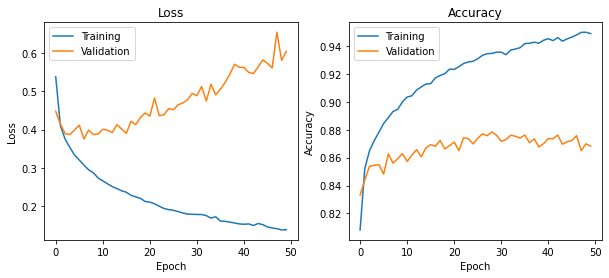

In [28]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

class MLP:
    def __init__(self, n_inputs, n_hidden, n_outputs):
        self.W1 = np.random.normal(loc=0.0, scale=1.0, size=(n_inputs, n_hidden)) / np.sqrt(n_inputs)
        self.b1 = np.zeros(n_hidden)
        self.W2 = np.random.normal(loc=0.0, scale=1.0, size=(n_hidden, n_outputs)) / np.sqrt(n_hidden)
        self.b2 = np.zeros(n_outputs)
        
    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.h1 = np.maximum(self.z1, 0)
        self.z2 = self.h1 @ self.W2 + self.b2
        exp_z2 = np.exp(self.z2)
        self.probs = exp_z2 / np.sum(exp_z2, axis=1, keepdims=True)
        return self.probs

    def backward(self, grad, X_batch):
        d_z2 = self.probs - grad
        self.d_W2 = self.h1.T @ d_z2
        self.d_b2 = np.sum(d_z2, axis=0)
        d_h1 = d_z2 @ self.W2.T
        d_z1 = d_h1.copy()
        d_z1[self.z1 < 0] = 0
        self.d_W1 = X_batch.T @ d_z1
        self.d_b1 = np.sum(d_z1, axis=0)
        
    def update_parameters_nesterov_momentum(self, grad, learning_rate, momentum):
        V_d_W2_prev = self.V_d_W2
        V_d_b2_prev = self.V_d_b2
        V_d_W1_prev = self.V_d_W1
        V_d_b1_prev = self.V_d_b1

        self.V_d_W2 = momentum * self.V_d_W2 - learning_rate * self.d_W2
        self.W2 += -momentum * V_d_W2_prev + (1 + momentum) * self.V_d_W2
        self.V_d_b2 = momentum * self.V_d_b2 - learning_rate * self.d_b2
        self.b2 += -momentum * V_d_b2_prev + (1 + momentum) * self.V_d_b2
        self.V_d_W1 = momentum * self.V_d_W1 - learning_rate * self.d_W1
        self.W1 += -momentum * V_d_W1_prev + (1 + momentum) * self.V_d_W1
        self.V_d_b1 = momentum * self.V_d_b1 - learning_rate * self.d_b1
        self.b1 += -momentum * V_d_b1_prev + (1 + momentum) * self.V_d_b1

    def train(self, X, y, X_val, y_val, learning_rate=0.001, momentum=0.9,
              epochs=10, batch_size=64, print_progress=True):
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        self.V_d_W2 = np.zeros_like(self.W2)
        self.V_d_b2 = np.zeros_like(self.b2)
        self.V_d_W1 = np.zeros_like(self.W1)
        self.V_d_b1 = np.zeros_like(self.b1)
        train_losses, train_accuracies = [], []
        val_losses, val_accuracies = [], []
        test_losses, test_accuracies = [], []
        for epoch in range(epochs):
            epoch_loss = 0
            epoch_accuracy = 0
            for i in range(0, n_samples, batch_size):
                # Mini-batch gradient descent
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]

                # Forward pass
                probs = self.forward(X_batch)

                # Compute loss and accuracy
                loss = -np.sum(y_batch * np.log(probs)) / batch_size
                epoch_loss += loss
                epoch_accuracy += np.mean(np.argmax(probs, axis=1) == np.argmax(y_batch, axis=1))

                # Backward pass
                self.backward(y_batch, X_batch)

                # Update parameters with Nesterov momentum optimizer
                self.update_parameters_nesterov_momentum(y_batch, learning_rate, momentum)

            # Compute validation loss and accuracy
            val_probs = self.forward(X_val)
            val_loss = -np.sum(y_val * np.log(val_probs)) / X_val.shape[0]
            val_accuracy = np.mean(np.argmax(val_probs, axis=1) == np.argmax(y_val, axis=1))
            train_losses.append(epoch_loss / n_batches)
            train_accuracies.append(epoch_accuracy / n_batches)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            if print_progress:
                print("Epoch {0}: loss = {1:.4f}, accuracy = {2:.4f}, val_loss = {3:.4f}, val_accuracy = {4:.4f}".format(
                    epoch+1, epoch_loss / n_batches, epoch_accuracy / n_batches, val_loss, val_accuracy))

        return train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies
    
# Load MNIST data
(X, y), (_, _) = fashion_mnist.load_data()

# Flatten and normalize
X = X.reshape(X.shape[0], -1) / 255.0

# Split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2/(1-0.2), random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)


input_size = X_train.shape[1]
hidden_size = 128
output_size = 10
#learning_rate = 0.001
#batch_size = 128
epochs = 10

model = MLP(input_size, hidden_size, output_size)
train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies = model.train(X_train, y_train,X_val, y_val,learning_rate=0.001, momentum=0.9,
              epochs=50, batch_size=64, print_progress=True)

test_probs = model.forward(X_test)
test_accuracy = np.mean(np.argmax(test_probs, axis=1) == np.argmax(y_test, axis=1))
print("Test accuracy:", test_accuracy)

# Plot the training, validation, and test loss and accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training")
plt.plot(val_losses, label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training")
plt.plot(val_accuracies, label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()